Goal: assess performance of tensor decompsition, and in particular the "how" paramater, in the presence of changing/missing cell types across contexts

In [2]:
suppressPackageStartupMessages({
    library(plyr, quietly = T)
    library(reshape2, quietly = T)
    
    library(car, quietly = T)
    
    library(ggplot2, quietly = T)
    library(ggpubr, quietly = T)
    library(RColorBrewer)

})

seed <- 888
set.seed(seed)
n.cores <- 15

env.name<-'tc2c_benchmark'
data.path<-'/data/hratch/ccc_protocols/'

Load the data:

In [3]:
res.df_<-read.csv(paste0(data.path, 'interim/', 'missing_vals_benchmark.csv'))
res.df<-res.df_[colnames(res.df_) != 'X']

fill.type<-c('masked - NaN', 'not masked - Zero')
colnames(res.df)<-c(colnames(res.df)[!(colnames(res.df) %in% c('corrindex.masked', 'corrindex.zeros'))], 
                    fill.type)
res.df<-melt(res.df, id=colnames(res.df)[!(colnames(res.df) %in% fill.type)], 
             value.name = 'corrindex', variable.name = 'fill.value')
res.df[['fill.value']]<-factor(res.df$fill.value, levels = fill.type)

In [4]:
head(res.df)

,iteration,celltype.fraction,lr.fraction,context.fraction,celltype.consistent,lr.consistent,missing.fraction,fill.value,corrindex
,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<fct>,<dbl>
1,1,0.1666667,0.1,0.2,1,1,0.12511111,masked - NaN,0.9885537
2,2,0.1666667,0.1,0.2,1,0,0.10711111,masked - NaN,0.9931618
3,3,0.1666667,0.1,0.2,0,1,0.09120370,masked - NaN,0.9949519
4,4,0.1666667,0.1,0.2,0,0,0.08644444,masked - NaN,0.9959650
5,5,0.1666667,0.1,0.4,1,1,0.16111111,masked - NaN,0.9939591
6,6,0.1666667,0.1,0.4,1,0,0.18922222,masked - NaN,0.9838905


## Analysis 1: Missing Indices Effect

Does the fraction of missing indices effect the CorrIndex?

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


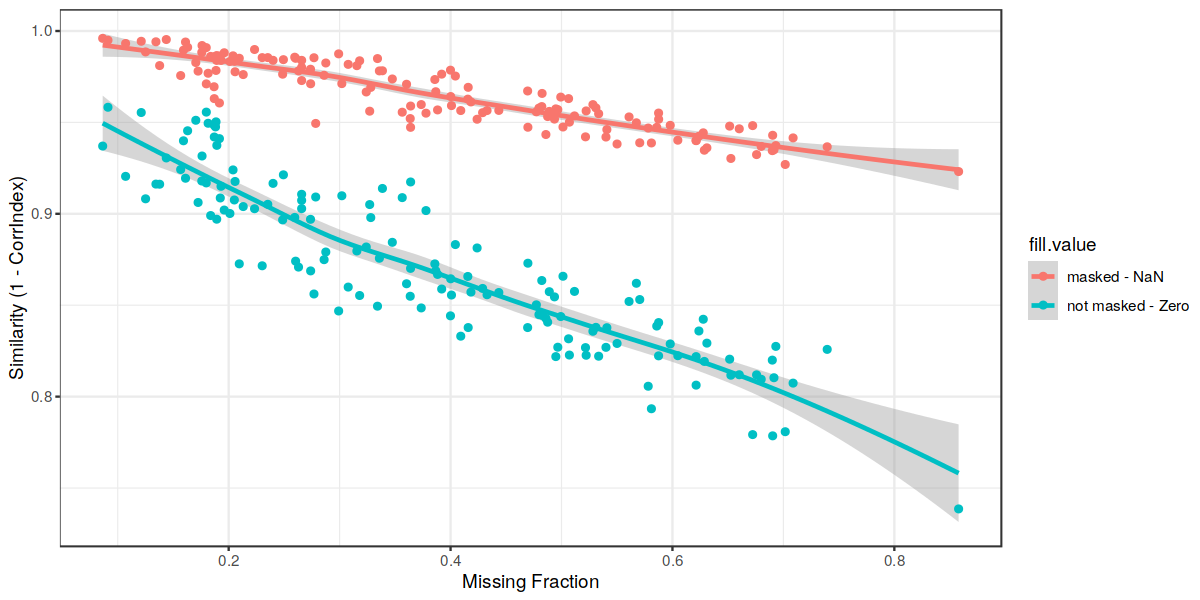

In [37]:
h_ = 5
w_ = 10
options(repr.plot.height=h_, repr.plot.width=w_)

g1<-ggplot(res.df, aes(x=missing.fraction, y=corrindex, color = fill.value)) +
    geom_smooth() + geom_point() + theme_bw() +
    ylab("Similarity (1 - CorrIndex)") + xlab('Missing Fraction')
g1

What is the minimum similarity value when filling with NaN?

In [38]:
min.corr.na<-min(res.df[res.df$fill.value == 'masked - NaN', 'corrindex'])

res.df[res.df$corrindex == min.corr.na, ]

,iteration,celltype.fraction,lr.fraction,context.fraction,celltype.consistent,lr.consistent,missing.fraction,fill.value,corrindex
,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<fct>,<dbl>
144,144,0.6666667,0.5,0.6,0,0,0.8579259,masked - NaN,0.9231106


What is the minimum similarity value when filling with 0?

In [39]:
min.corr.z<-min(res.df[res.df$fill.value == 'not masked - Zero', 'corrindex'])

res.df[res.df$corrindex == min.corr.z, ]

,iteration,celltype.fraction,lr.fraction,context.fraction,celltype.consistent,lr.consistent,missing.fraction,fill.value,corrindex
,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<fct>,<dbl>
288,144,0.6666667,0.5,0.6,0,0,0.8579259,not masked - Zero,0.7385877


Run some statistics:

In [40]:
m1<-glm(data = res.df[res.df$fill.value == 'masked - NaN',], 
        formula = corrindex ~ missing.fraction)
summary(m1)


Call:
glm(formula = corrindex ~ missing.fraction, data = res.df[res.df$fill.value == 
    "masked - NaN", ])

Deviance Residuals: 
      Min         1Q     Median         3Q        Max  
-0.025924  -0.004636   0.001228   0.005653   0.014811  

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       1.001651   0.001557  643.40   <2e-16 ***
missing.fraction -0.094419   0.003654  -25.84   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 6.073744e-05)

    Null deviance: 0.0491794  on 143  degrees of freedom
Residual deviance: 0.0086247  on 142  degrees of freedom
AIC: -985.45

Number of Fisher Scoring iterations: 2


In [21]:
m2<-glm(data = res.df[res.df$fill.value == 'not masked - Zero',], 
        formula = corrindex ~ missing.fraction)
summary(m2)


Call:
glm(formula = corrindex ~ missing.fraction, data = res.df[res.df$fill.value == 
    "not masked - Zero", ])

Deviance Residuals: 
      Min         1Q     Median         3Q        Max  
-0.044025  -0.013127  -0.001166   0.013796   0.041355  

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.959175   0.003772  254.29   <2e-16 ***
missing.fraction -0.228333   0.008853  -25.79   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.0003565687)

    Null deviance: 0.287805  on 143  degrees of freedom
Residual deviance: 0.050633  on 142  degrees of freedom
AIC: -730.57

Number of Fisher Scoring iterations: 2


basic interpretation of additive model, with masked values being the baseline: https://www.theanalysisfactor.com/interpreting-regression-coefficients/

In [22]:
m3<-glm(data = res.df, 
        formula = corrindex ~ missing.fraction + fill.value)
summary(m3)


Call:
glm(formula = corrindex ~ missing.fraction + fill.value, data = res.df)

Deviance Residuals: 
      Min         1Q     Median         3Q        Max  
-0.056212  -0.011804  -0.000569   0.012636   0.051401  

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  1.027578   0.002868  358.35   <2e-16 ***
missing.fraction            -0.161376   0.006212  -25.98   <2e-16 ***
fill.valuenot masked - Zero -0.094330   0.002208  -42.72   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.0003510427)

    Null deviance: 0.97765  on 287  degrees of freedom
Residual deviance: 0.10005  on 285  degrees of freedom
AIC: -1468.6

Number of Fisher Scoring iterations: 2


basic interpretation of interactive model, with masked values being the baseline:
https://www.theanalysisfactor.com/interpreting-interactions-in-regression/

In [24]:
m4<-glm(data = res.df, 
        formula = corrindex ~ missing.fraction*fill.value)
summary(m4)


Call:
glm(formula = corrindex ~ missing.fraction * fill.value, data = res.df)

Deviance Residuals: 
      Min         1Q     Median         3Q        Max  
-0.044025  -0.007359   0.000392   0.007854   0.041355  

Coefficients:
                                              Estimate Std. Error t value
(Intercept)                                   1.001651   0.002885  347.14
missing.fraction                             -0.094419   0.006773  -13.94
fill.valuenot masked - Zero                  -0.042477   0.004081  -10.41
missing.fraction:fill.valuenot masked - Zero -0.133915   0.009578  -13.98
                                             Pr(>|t|)    
(Intercept)                                    <2e-16 ***
missing.fraction                               <2e-16 ***
fill.valuenot masked - Zero                    <2e-16 ***
missing.fraction:fill.valuenot masked - Zero   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family ta

In [41]:
mapper<-c('S0', 'missing.fraction', 'fill.value', 'missing.fraction:fill.value')
names(mapper)<-c('(Intercept)', 'missing.fraction', 'fill.valuenot masked - Zero', 
                'missing.fraction:fill.valuenot masked - Zero')

format.model<-function(glm.out, mapper = mapper){
    df<-coef(summary(glm.out))
    colnames(df)<-c(colnames(df)[1:3], 'p.val') 
    df<-as.data.frame(df)
    df[['BH.fdr']]<-p.adjust(df$p.val, method = 'BH')
    
    sig.threshold = 0.05
    sig.colname<-paste0('Significant')# (q <= ', sig.threshold, ')')
    df[[sig.colname]]<-'yes'
    df[[sig.colname]]<-factor(df[[sig.colname]], levels = c('yes', 'no'))
    df[df$BH.fdr > sig.threshold, sig.colname]<-'no'
    
    df[['x.label']]<-unlist(unname(mapper[rownames(df)]))
    df[['x.label']]<-factor(df[['x.label']], levels = unname(mapper))#, ordered = TRUE)
    
    return(df)
}

multi.vline<-function(xint, yint){
    geom_segment(aes(x = xint, xend = xint, y = 0, yend = yint), color = "gray", linetype = 'longdash')
}

In [42]:
model.ids<-c('Masked Only', 'Zeros Only', 'Additive', 'Interaction')
all.lms<-list(m1, m2, m3, m4)
all.viz.dfs<-lapply(all.lms, format.model, mapper = mapper)
all.viz.df<-do.call(rbind, 
        mapply(cbind, all.viz.dfs, "model.id"=c('Masked Only', 'Zeros Only', 'Additive', 'Interaction'), SIMPLIFY=F))
all.viz.df[['model.id']]<-factor(all.viz.df$model.id, levels=model.ids)

In [30]:
all.viz.df<-all.viz.df[all.viz.df$x.label != 'S0', ]

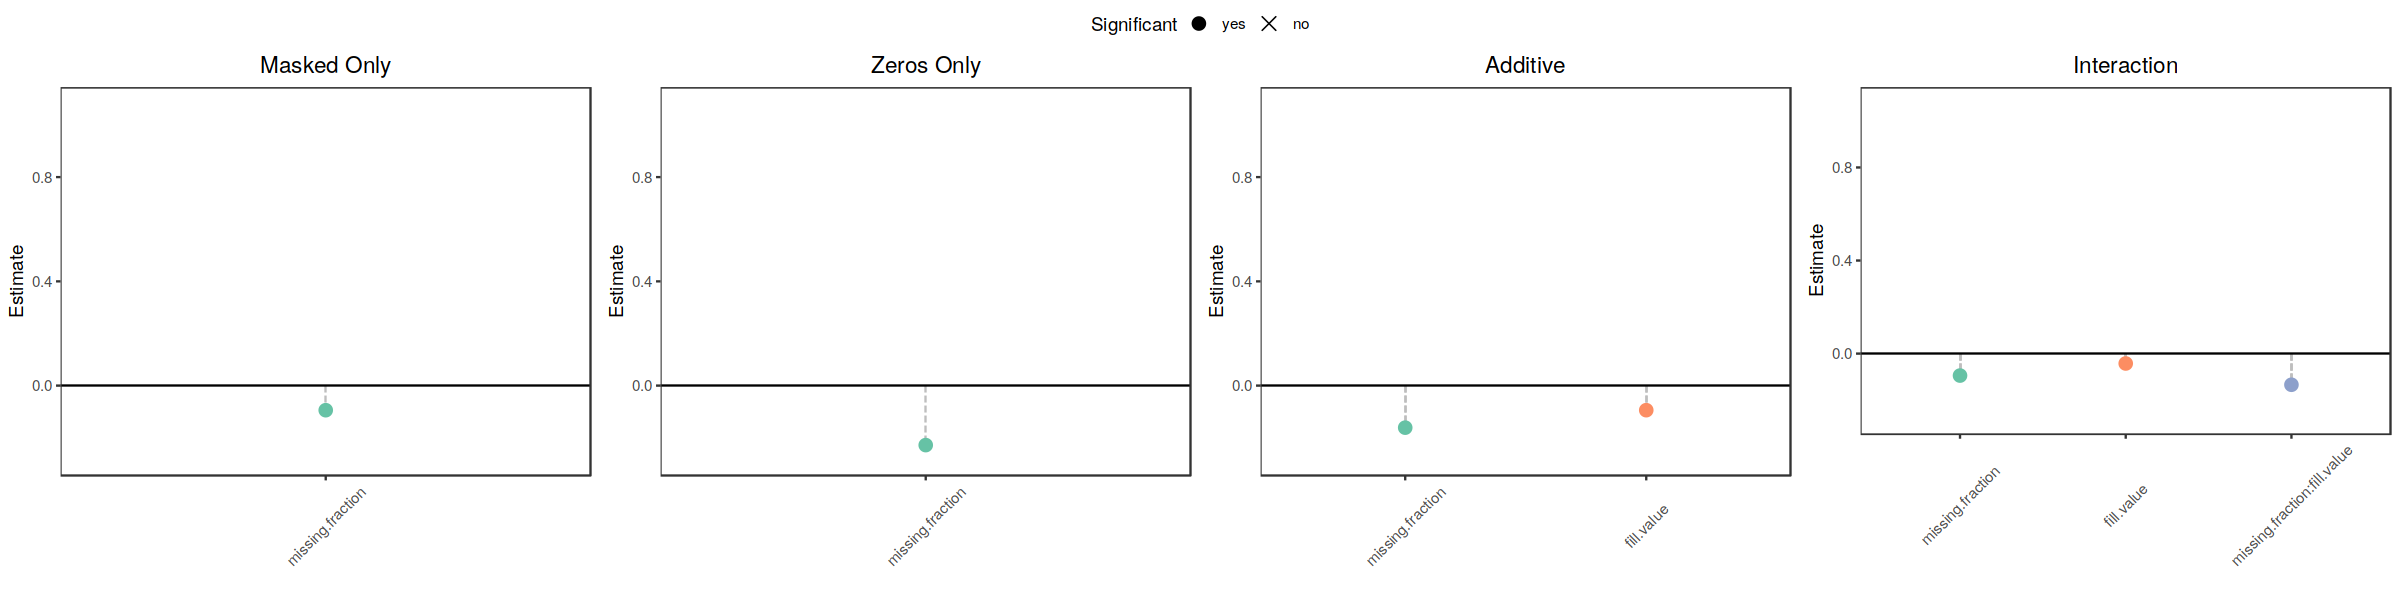

In [43]:
ylim_upper = 0.05
ylim_lower = 0.05

i = 1
viz.df<-format.model(all.lms[[i]], mapper)
viz.df<-viz.df[viz.df$x.label != 'S0', ]
g3A<-ggplot(data = viz.df, aes(x = x.label, y = Estimate, shape = Significant, color = x.label))+
mapply(multi.vline, viz.df[['x.label']], viz.df[['Estimate']])+
geom_point(size = 3.5) + 
geom_hline(yintercept = 0)+#, linetype, color, size)
ylim(min(all.viz.df$Estimate) - ylim_lower, max(all.viz.df$Estimate) + ylim_upper)+
scale_shape_manual(values = c(16, 4), labels = c('yes', 'no'), drop = F)+
guides(colour = "none")+
scale_x_discrete(limits = viz.df[['x.label']])+
scale_color_manual(values = RColorBrewer::brewer.pal(n = length(unique(all.viz.df$x.label)), name = 'Set2'))+
theme_bw() +   
theme(plot.background = element_blank(), panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
     plot.title = element_text(hjust = 0.5), 
     axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5))+ 
ggtitle(model.ids[[i]]) + xlab('')

#######
i = 2
viz.df<-format.model(all.lms[[i]], mapper)
viz.df<-viz.df[viz.df$x.label != 'S0', ]
g3B<-ggplot(data = viz.df, aes(x = x.label, y = Estimate, shape = Significant, color = x.label))+
mapply(multi.vline, viz.df[['x.label']], viz.df[['Estimate']])+
geom_point(size = 3.5) + 
geom_hline(yintercept = 0)+#, linetype, color, size)
ylim(min(all.viz.df$Estimate) - ylim_lower, max(all.viz.df$Estimate) + ylim_upper)+
scale_shape_manual(values = c(16, 4), labels = c('yes', 'no'), drop = F)+
guides(colour = "none")+
scale_x_discrete(limits = viz.df[['x.label']])+
scale_color_manual(values = RColorBrewer::brewer.pal(n = length(unique(all.viz.df$x.label)), name = 'Set2'))+
theme_bw() +   
theme(plot.background = element_blank(), panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
     plot.title = element_text(hjust = 0.5), 
     axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5))+ 
ggtitle(model.ids[[i]]) + xlab('')

#######
i = 3
viz.df<-format.model(all.lms[[i]], mapper)
viz.df<-viz.df[viz.df$x.label != 'S0', ]
g3C<-ggplot(data = viz.df, aes(x = x.label, y = Estimate, shape = Significant, color = x.label))+
mapply(multi.vline, viz.df[['x.label']], viz.df[['Estimate']])+
geom_point(size = 3.5) + 
geom_hline(yintercept = 0)+#, linetype, color, size)
ylim(min(all.viz.df$Estimate) - ylim_lower, max(all.viz.df$Estimate) + ylim_upper)+
scale_shape_manual(values = c(16, 4), labels = c('yes', 'no'), drop = F)+
guides(colour = "none")+
scale_x_discrete(limits = viz.df[['x.label']])+
scale_color_manual(values = RColorBrewer::brewer.pal(n = length(unique(all.viz.df$x.label)), name = 'Set2'))+
theme_bw() +   
theme(plot.background = element_blank(), panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
     plot.title = element_text(hjust = 0.5), 
     axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5))+ 
ggtitle(model.ids[[i]]) + xlab('')

#######
i = 4
viz.df<-format.model(all.lms[[i]], mapper)
viz.df<-viz.df[viz.df$x.label != 'S0', ]
g3D<-ggplot(data = viz.df, aes(x = x.label, y = Estimate, shape = Significant, color = x.label))+
mapply(multi.vline, viz.df[['x.label']], viz.df[['Estimate']])+
geom_point(size = 3.5) + 
geom_hline(yintercept = 0)+#, linetype, color, size)
ylim(min(all.viz.df$Estimate) - ylim_lower, max(all.viz.df$Estimate) + ylim_upper)+
scale_shape_manual(values = c(16, 4), labels = c('yes', 'no'), drop = F)+
guides(colour = "none")+
scale_x_discrete(limits = viz.df[['x.label']])+
scale_color_manual(values = RColorBrewer::brewer.pal(n = length(unique(all.viz.df$x.label)), name = 'Set2'))+
theme_bw() +   
theme(plot.background = element_blank(), panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
     plot.title = element_text(hjust = 0.5), 
     axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5))+
ggtitle(model.ids[[i]]) + xlab('')


h_ = 5
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)
g3<-ggpubr::ggarrange(g3A, g3B, g3C, g3D, # list of plots
                  common.legend = T, ncol = 4)
# g3<-cowplot::plot_grid(g3A, g3B, g3C, g3D, ncol = 4)

g3

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


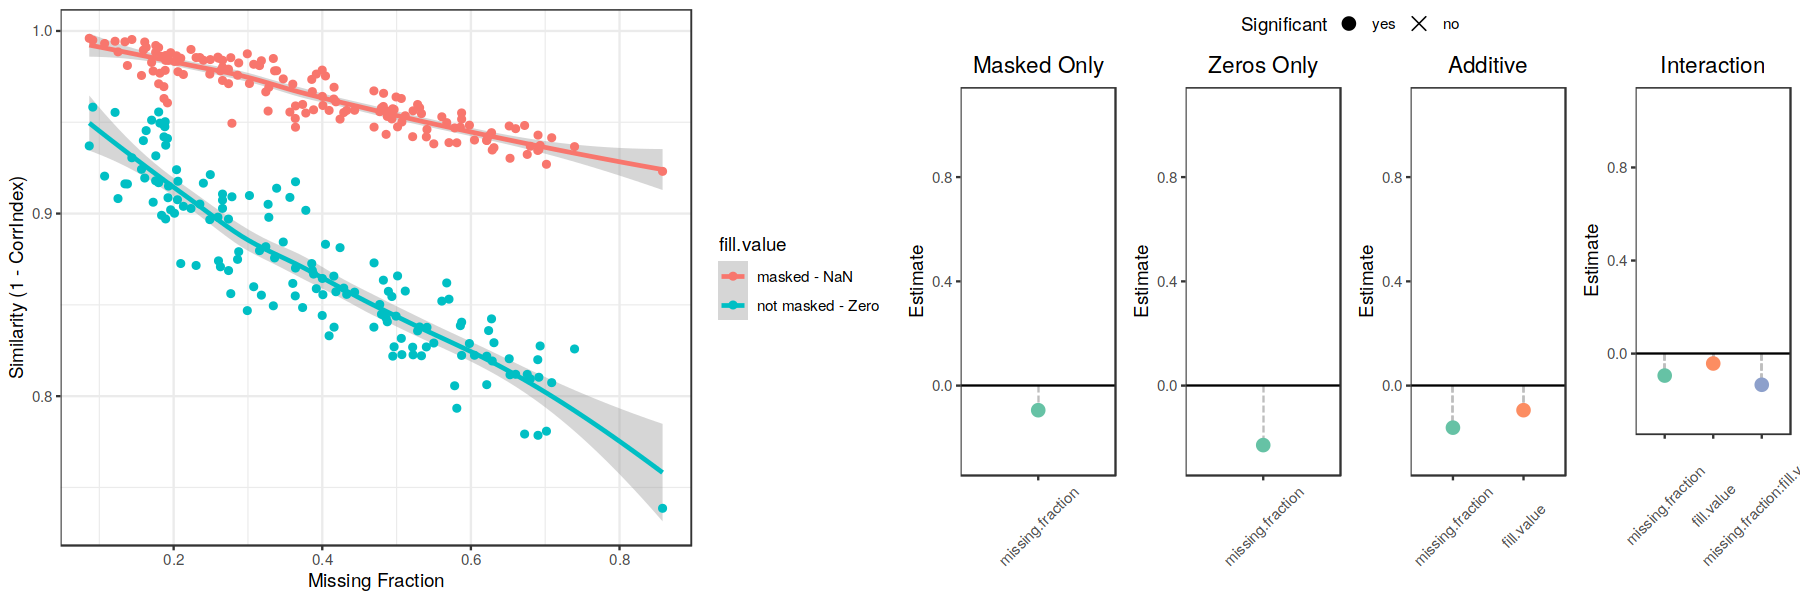

In [44]:
h_ = 5
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

g_final<-ggpubr::ggarrange(g1, g3, ncol = 2)
g_final

# Analysis 2: Specificity of LRs/Celltypes Removed

Here, we see whether removing the same LRs and cell types across samples (rather than removing rnaomd ones in each sample) changes the results):

In [404]:
consist.mapper<-c('no', 'yes')
names(consist.mapper)<-c('0', '1')

for (consist.col in c('celltype.consistent', 'lr.consistent')){
    res.df[[consist.col]]<-unname(consist.mapper[as.character(res.df[[consist.col]])])
    res.df[[consist.col]]<-factor(res.df[[consist.col]], levels = c('no', 'yes'))
}

In [406]:
m5<-glm(data = res.df, 
        formula = corrindex ~ missing.fraction + fill.value + celltype.consistent + lr.consistent)
summary(m5)


Call:
glm(formula = corrindex ~ missing.fraction + fill.value + celltype.consistent + 
    lr.consistent, data = res.df)

Deviance Residuals: 
      Min         1Q     Median         3Q        Max  
-0.054013  -0.011554  -0.000628   0.011944   0.050941  

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  1.025601   0.003229 317.622   <2e-16 ***
missing.fraction            -0.161635   0.006217 -25.999   <2e-16 ***
fill.valuenot masked - Zero -0.094330   0.002209 -42.708   <2e-16 ***
celltype.consistentyes       0.002483   0.002209   1.124    0.262    
lr.consistentyes             0.001671   0.002210   0.756    0.450    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.0003512467)

    Null deviance: 0.977650  on 287  degrees of freedom
Residual deviance: 0.099403  on 283  degrees of freedom
AIC: -1466.5

Number of Fisher Scoring iterations: 2


Whether or not cell types or LRs are removed consistently does not impact results, as observed from the lack of significance of the LM coefficients. This indicates that tensor decomposition is consistent whether or not missing indices are random or systematic across samples.

# Analysis 3:

We want to see how missing LRs vs celltypes may affect the corrindex similarity. 

First, we want to control for the overall missing fraction and fill type, since these are our suspected likely drivers of similarity. Hoever, we must consider whether there is an issue of multicollinearity, since the missing LR and cell type fractions drive the overall missing fraction. Visually, we see that these variables seem to be related:

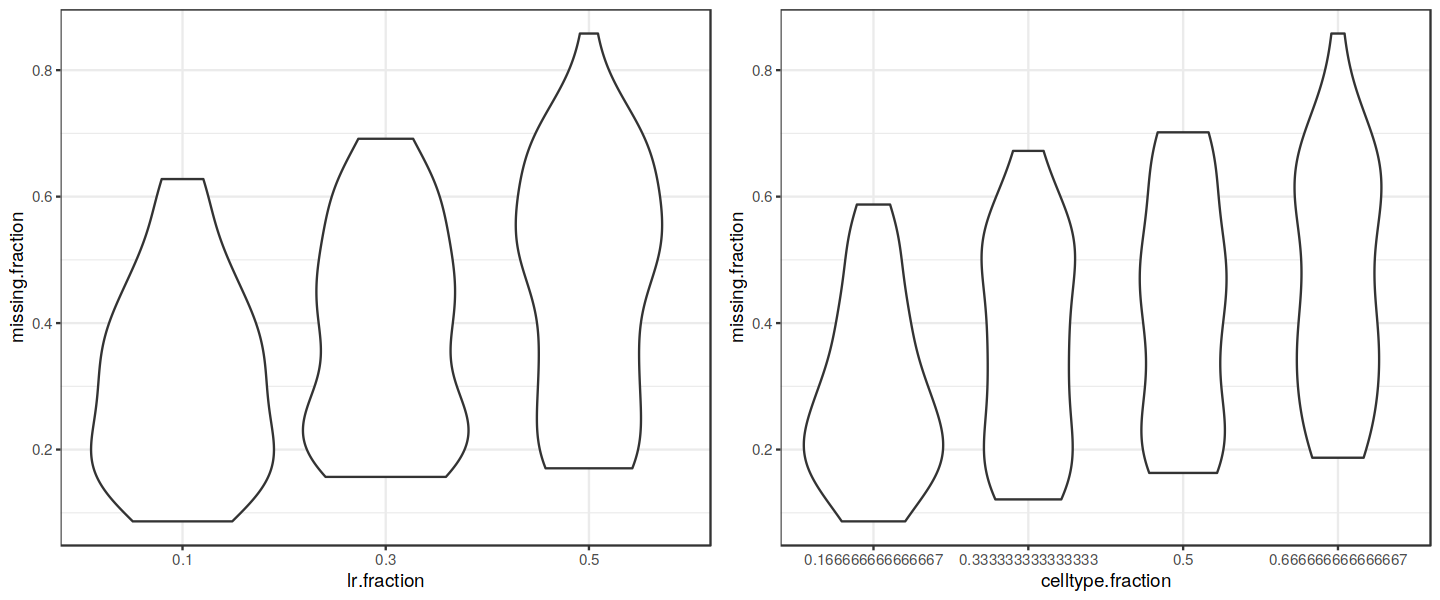

In [463]:
viz.df<-res.df_[colnames(res.df_) != 'X']
for (frac.col.name in c('lr.fraction', 'celltype.fraction')){#, 'context.fraction')){
    viz.df[[frac.col.name]]<-factor(viz.df[[frac.col.name]], levels = sort(unique(res.df[[frac.col.name]])))

}

h_ = 5
w_ = 12
options(repr.plot.height=h_, repr.plot.width=w_)

g4A<-ggplot(data = viz.df, aes(x = lr.fraction, y = missing.fraction)) + geom_violin() + theme_bw()
g4B<-ggplot(data = viz.df, aes(x = celltype.fraction, y = missing.fraction)) + geom_violin() + theme_bw()
#g4C<-ggplot(data = viz.df, aes(x = context.fraction, y = missing.fraction)) + geom_violin() + theme_bw()


g4<-ggpubr::ggarrange(g4A, g4B, ncol = 2)#g4C, ncol = 3)
g4

However, the [vif](https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/) indicates that this shouldn't be an issue in our model:

In [464]:
m6<-glm(data = res.df, 
        formula = corrindex ~ missing.fraction + fill.value + lr.fraction + celltype.fraction)
car::vif(m6)

missing.fraction        fill.value       lr.fraction celltype.fraction 
         1.357836          1.000000          1.174825          1.183011

So, let's simply use this model that controls for the overall missing fraction and the fill type while checking whether LRs or cell types specifically have a more distinct effect on corrindex similarity:

In [469]:
summary(m6)


Call:
glm(formula = corrindex ~ missing.fraction + fill.value + lr.fraction + 
    celltype.fraction, data = res.df)

Deviance Residuals: 
      Min         1Q     Median         3Q        Max  
-0.058823  -0.012178   0.000375   0.012215   0.048220  

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  1.017449   0.003532 288.059  < 2e-16 ***
missing.fraction            -0.176945   0.006970 -25.386  < 2e-16 ***
fill.valuenot masked - Zero -0.094330   0.002126 -44.363  < 2e-16 ***
lr.fraction                  0.012248   0.007057   1.736   0.0837 .  
celltype.fraction            0.029959   0.006206   4.828 2.26e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.0003255291)

    Null deviance: 0.977650  on 287  degrees of freedom
Residual deviance: 0.092125  on 283  degrees of freedom
AIC: -1488.4

Number of Fisher Scoring iterations: 2


As indicated by the lack of significance in the coefficients, neither LRs or celltypes specifically drive similarity, but rather the overall missing fraction in the tensor and fill type used during decomposition. 